# Название проекта
Стратегия взаимодействия с пользователями на основе аналитических данных сети фитнес-центров «Культурист-датасаентист».

## Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил нас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей, с помощью которых мне надо подготовить план действий по удержанию клиентов.

## Задачи проекта
Провести анализ и подготовить план действий по удержанию клиентов, а именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   1. выделить целевые группы клиентов;
   2. предложить меры по снижению оттока;
   3. определить другие особенности взаимодействия с клиентами.

# Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.info()
display(gym.head())
print('Дубликатов:', gym.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Дубликатов: 0


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- Churn — факт оттока в текущем месяце(1 - факт оттока, 0 - факт оставания);
- Текущие поля в датасете:
  - Данные пользователя за предыдущий до проверки факта оттока месяц:
      - gender — пол (0 - мужчины, 1 - женщины)
      - Near_Location — проживание или работа в районе, где находится фитнес-центр
      - Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
      - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
      - Phone — наличие контактного телефона
      - Age — возраст
      - Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
  - Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
  - Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
  - Group_visits — факт посещения групповых занятий
  - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
  - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
  - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

Поменяем названия столбцов на более удобные:

In [3]:
gym.columns = gym.columns.str.lower()
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## Выводы занрузки данных
Посмотрели данные, поменяли названия столбцов для более удобного использования, посмотрели пропуски(их нет) и дубликаты. Перейдем к исследовательскому анализу данных.

# Исследовательский анализ данных (EDA)
Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [4]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Можно видеть, что средний лайфтам почти 4 месяца, есть пользователи очень лояльные к фитнес-центру(макимальное значение - 31 месяц), средний возраст клиентов 29 лет. Обычно пользователи покупают абонемент на месяц логично, что медианное значение окончания текущего абонемента тоже месяц. Средние частоты посещений за все время и за последний месяц тоже близки друг к другу. Средняя суммерная выручка от смежных услуг почти 147 долларов, что выглядит правдоподобно. По стандартным отклонениям можно сказать, что у нас нет каких огромных выбросов, но всегда находятся пользователи, которые и тратят больше денег и ходят чаще в тренажерный зал. Можно сказать, что у нас нет сильносмещенных данных. Теперь посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

Типичный клиент выглядит так: Он живет или работает в районе фитнес-центра, он скорее всего пришел не по акции "Приведи друга", у нас есть данные о его номере телефона, его абонемент длится 5 месяцев(но у нас такого варианта нет, поэтому округлим до 6 месяцев), он не посещает групповые тренировки, ему 29 лет, он тратит на смежные услуги 146 у.е.(долларов скорее всего), его абонемнт заканчивается через 4 месяца, впервые он контактировал с фитнес-центром почти 4 месяца назад и у него 2 тренировки в неделю.

У переменных довольно разные по величине стандартные отклонения. Это говорит о том, что их возможно нужно стандартизировать перед обучением. Для логистической регрессии и дерева это не обязательно, но можно будет стандартизировать все, а потом уже гонять модели.

In [5]:
gym.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Можно увидеть отличия пользователей: ушедшие реже живут или работают в районе фитнес-центра, реже являются работниками компаний-партнеров, длительность их абонемента меньше двух месяцев, вотличие от лояльных нам пользователей, у которых в среднем длительность текущего абонемента составляет почти полгода, ушедшие реже посещают групповые занятия, они моложе на три года, относительно остающихся пользователей, уходящие также меньше тратятся на смежные услуги, лайфтайм их не больше месяца, значит они попробовали и больше не появлялись, а еще они реже ходят особенно в последний месяц, их посещаемость ниже в два раза относительно оставшихся. Теперь построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [6]:
#функция для отрисовки распредления и ящика с усами для непрерывных признаков
def nepreriv_feature_plots(df, feature, title):
    fig, ax = plt.subplots(figsize = (16, 4))

    sns.distplot(df[df['churn']==0][feature], label = 'Активные клиенты', ax = plt.subplot(1, 2, 1)) 
    sns.distplot(df[df['churn']==1][feature], label = 'Отток', ax = plt.subplot(1, 2, 1))
    
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    sns.boxplot(y = feature, x = 'churn', data = df, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([0, 1], ('Активные клиенты', 'Отток'))

    fig.suptitle(title)
    plt.show()

In [7]:
#функция для отрисовки гистограммы и ящика с усами для категориальных признаков
def categor_feature_plots(df, feature, title):  
    fig, ax = plt.subplots(figsize = (16, 4))
    
    report = df.pivot_table(index = feature, columns = 'churn', values = 'age', aggfunc = 'count')
    report.plot(kind = 'bar', stacked = True, alpha = 0.5, ax = plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks()
    plt.legend(('Активные клиенты', 'Отток'))

    group = df.groupby([feature, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = feature, y = 'count', data=group, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([0, 1], ('Активные клиенты', 'Отток'))

    fig.suptitle(title)
    plt.show()

In [8]:
#списки с названиями непрерывных признаков и их заголовками
nepreriv_feature_list = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
              'avg_class_frequency_total', 'avg_class_frequency_current_month']
nepreriv_title_list = ['Возраст', 'Сумма смежных трат', 'Срок окончания действующего абонемента в месяцах', 
              'Время с момента первого обращения в фитнес-центр в месяцах', 'Средняя частота посещений в неделю за весь период', 
              'Средняя частота посещений в неделю за последний месяц']

#списки с названиями категориальных признаков и их заголовками
categor_feature_list = ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits']
categor_title_list = ['Пол', 'Проживание или работа в одном районе с фитнес-центром', 'Сотрудники компании-партнёра', 
                'Клиенты, пришедшие по акции "Приведи друга"', 'Наличие номера телефона', 'Длительность текущего абонемента в месяцах', 
                'Посещение групповых занятий']

nepreriv_features = pd.DataFrame({'feature': nepreriv_feature_list, 'title': nepreriv_title_list})
categor_features = pd.DataFrame({'feature': categor_feature_list, 'title': categor_title_list})

Посмотрим на непрерывные признаки(ящик с усами для более явного понимания медианы и межквартильного расстояния):

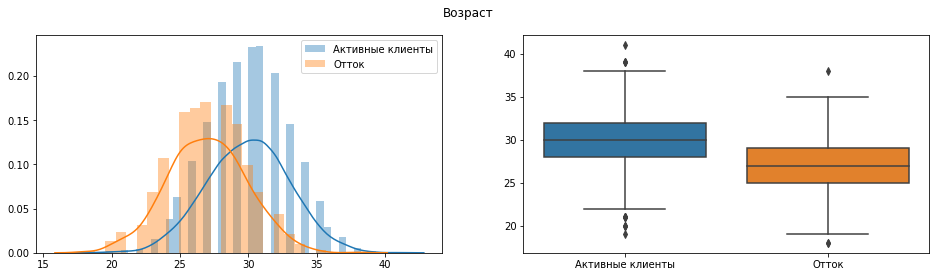

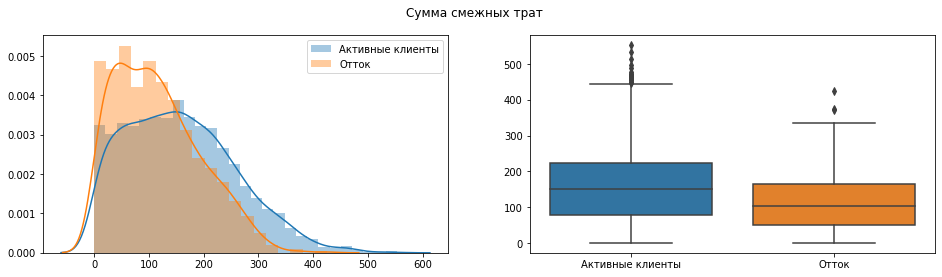

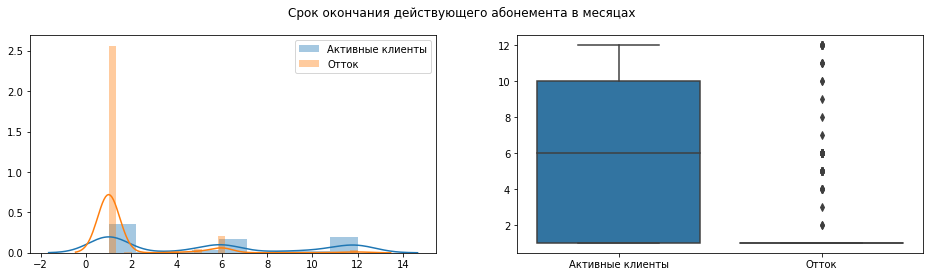

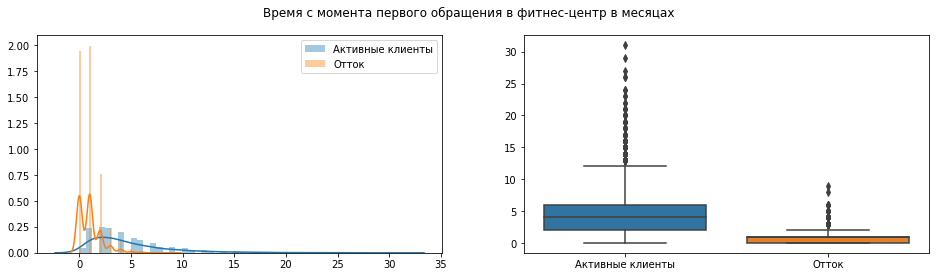

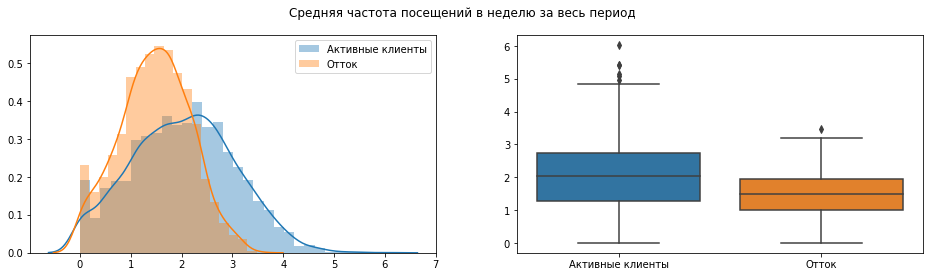

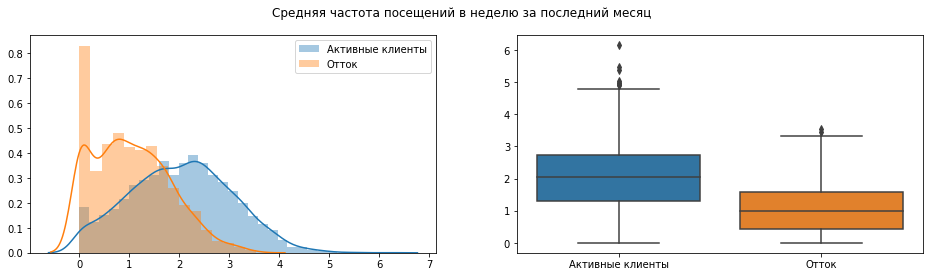

In [9]:
for index, row in nepreriv_features.iterrows():
    nepreriv_feature_plots(gym, row[0], row[1])

По графикам можно видеть, что пол распределен равномерно, но активные клиенты в среднем постарше. Распределение смежных трат у ушедших скошено влево, а оставшиеся клиенты тратят в среднем больше денег. У большинства ушедших клиентов заканчивался абонемент  в текущем месяце(месяц оттока). Попавшие в отток клиенты в основном посещают фитнес-центр по месячному абонементу. Средняя частота посещения за весь период за неделю выше у активных клиентов, в последний месяц картина та же. Теперь в зглянем на категориальный признаки.

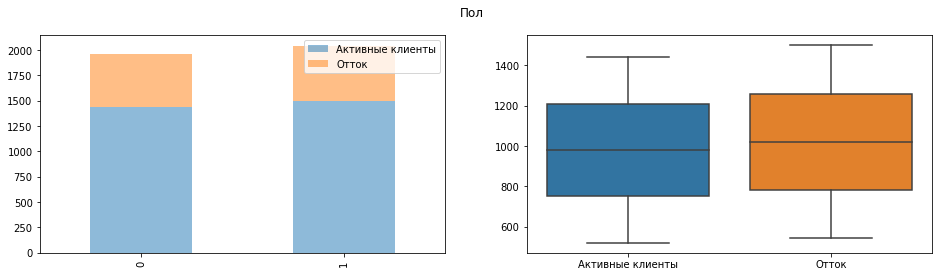

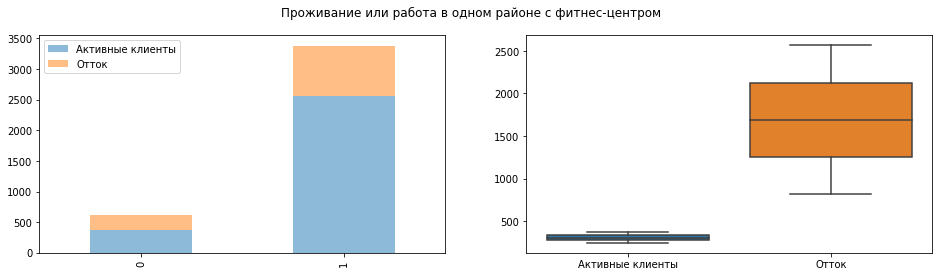

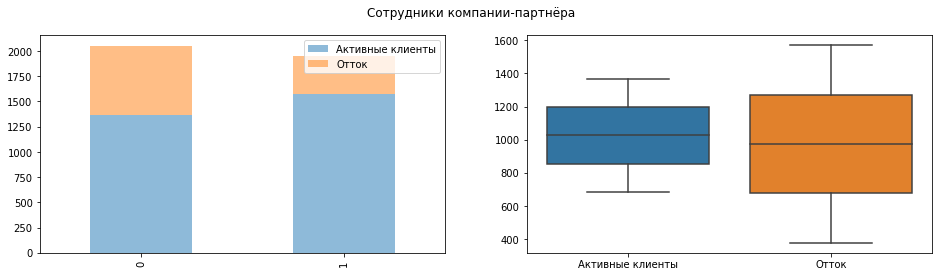

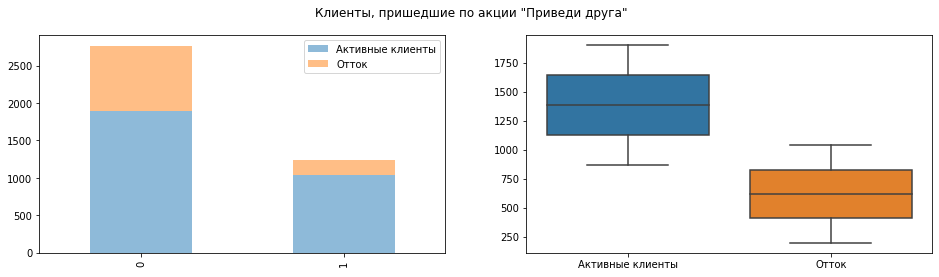

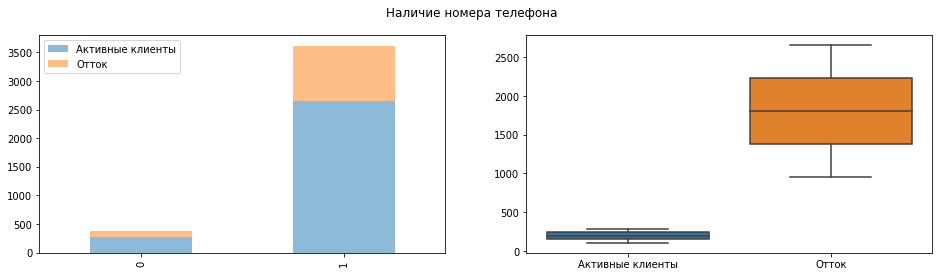

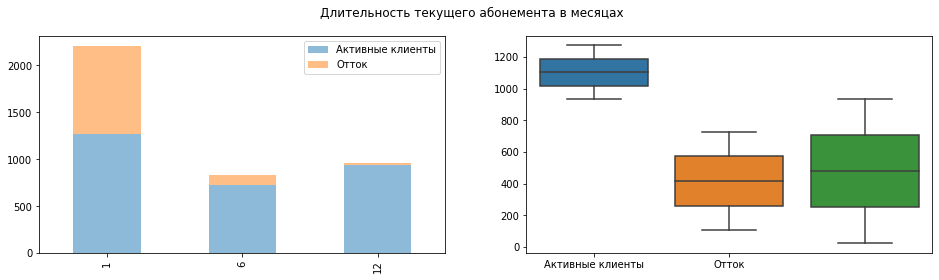

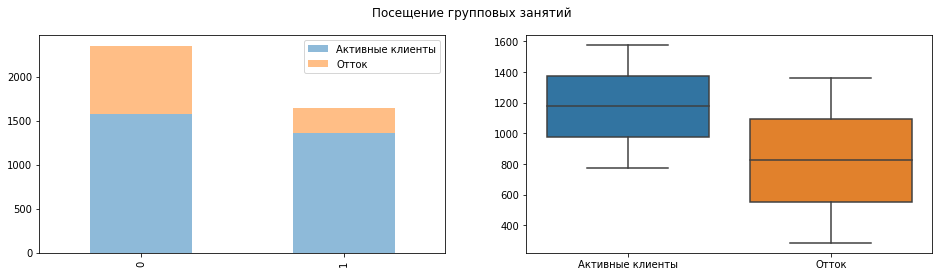

In [10]:
for index, row in categor_features.iterrows():
    categor_feature_plots(gym, row[0], row[1])

Здесь мы видим что пол распределён равномерно, как внутри оттока, так и в целом. Среди людей, живущих или работающих вне района фитнес-центра, доля попавших в отток значительно выше, чем среди тех, кто живет и работает рядом с фитнес-центром. Доля ушедших в отток сотрудников компаний-партнёров значительно меньше. Клиенты, пришедшие по акции "Приведи друга" реже попадают в отток.
Скорее всего наличие телефона в анкете никак не влияет на долю оттока. Больше всего клиентов, попавших в отток, среди тех, кто приобрел абонемент на месяц. Реже всего попадают в отток клиенты с 12-месячными абонементами. Клиенты, посещающие групповые программы, так же реже попадают в отток.

В целом распределения признаков активных клиентов ниже и шире распределений признаков оттока - это говорит о том, что вариативность признаков больше среди постоянных посетителей, в то время как нелояльные клиенты пользуются услугами клуба реже и в меньшем объёме.

Построим матрицу корреляций

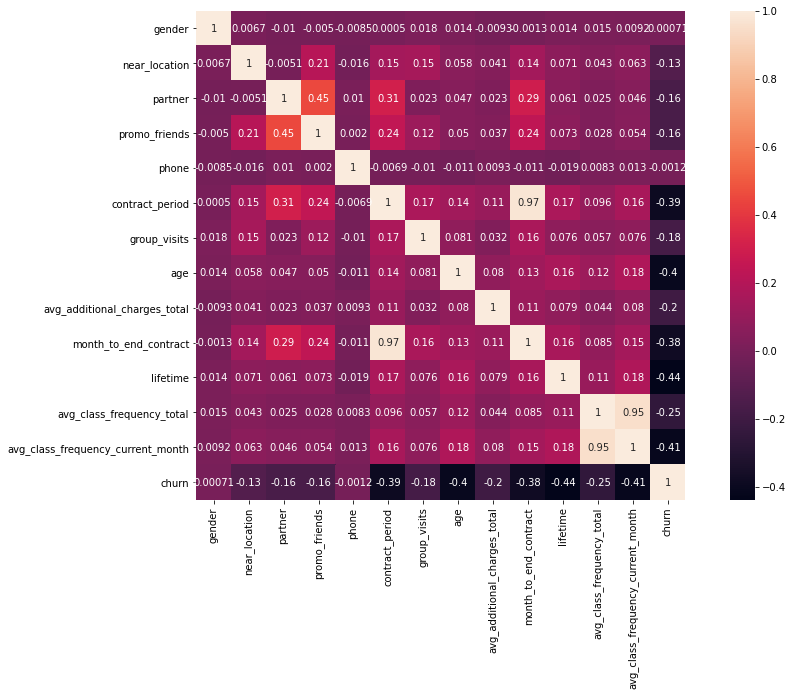

In [11]:
cm = gym.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(16, 9))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
    
plt.show()

Сильно положительно коррелирующих с оттоком признаков на карте не видно, кажется есть наоборот, признаки с обратной корреляцией. Больше остальных с целевой переменной(факт оттока) коррелирует lifetime клиента (чем он больше, тем меньше вероятность оттока и наоборот).Следующими по значимости следуют средняя частоста посещений клуба за последний месяц, возраст, срок действующего абонемента и количество месяцев до истечения абонемента(все так же с обратной корреляцией). Пол и наличие номера телефон никак не влияют на отток. Между собой сильно коррелируют две пары признаков: срок абонемента и количество месяцев до конца абонемента, а также средняя частота посещений за весь период и средняя частота посещений за последний месяц. Скорее всего, обе зависимости связаны с тем, что большинство абонементов приобретаются на 1 месяц.

## Выводы исследовательского анализа
Посмотрели на датасет, изучили средния значения и стандартные отклонения, заметили некоторые особенности: ушедшие реже живут или работают в районе фитнес-центра, реже являются работниками компаний-партнеров, длительность их абонемента меньше двух месяцев, вотличие от лояльных нам пользователей, у которых в среднем длительность текущего абонемента составляет почти полгода, ушедшие реже посещают групповые занятия, они моложе на три года, относительно остающихся пользователей, уходящие также меньше тратятся на смежные услуги, лайфтайм их не больше месяца, значит они попробовали и больше не появлялись, а еще они реже ходят особенно в последний месяц, их посещаемость ниже в два раза относительно оставшихся. Гистограмы и ящики с усами подтвердили наши предположения. Матрица корреляции показала, что сильно положительно коррелирующих с оттоком признаков не видно, есть наоборот, признаки с обратной корреляцией: lifetime клиента, средняя частоста посещений клуба за последний месяц, возраст, срок действующего абонемента и количество месяцев до истечения абонемента. А также составили портрет среднестатистического клиента.

# Модель прогнозирования оттока клиентов
Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.
Разобьем данные на обучающую и валидационную выборку. Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом. Оценим метрики accuracy, precision, recall и F1-мера для обеих моделей на валидационной выборке. Сравним по ним модели. А для начала уберем признаки, которые не коррелируют с целевой переменной - пол и наличие номера телефона.

In [12]:
gym_now = gym.drop(['gender', 'phone'], axis=1)
gym_now.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   near_location                      4000 non-null   int64  
 1   partner                            4000 non-null   int64  
 2   promo_friends                      4000 non-null   int64  
 3   contract_period                    4000 non-null   int64  
 4   group_visits                       4000 non-null   int64  
 5   age                                4000 non-null   int64  
 6   avg_additional_charges_total       4000 non-null   float64
 7   month_to_end_contract              4000 non-null   float64
 8   lifetime                           4000 non-null   int64  
 9   avg_class_frequency_total          4000 non-null   float64
 10  avg_class_frequency_current_month  4000 non-null   float64
 11  churn                              4000 non-null   int64

Напишем функцию для вывода метрик:

In [13]:
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

Теперь перейдем к моделям логистической регрессии и случайного леса:

In [14]:
#делим данные на признаки (матрица X) и целевую переменную (y)
X = gym_now.drop('churn', axis = 1)
y = gym_now['churn']

#делим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

#логистическая регрессия
#зададем алгоритм для нашей модели
log_model = LogisticRegression()

#обучаем модель
log_model.fit(X_train, y_train)

#делаем прогнозы
log_predictions = log_model.predict(X_test) 

In [15]:
#случайный лес
#обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

#преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#зададем алгоритм для модели на основе алгоритма случайного леса:
les_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

#обучим модель случайного леса:
les_model.fit(X_train_st, y_train)

#делаем прогнозы
les_predictions = les_model.predict(X_test_st)

Оценим полученные метрики:

In [16]:
print_all_metrics(y_test, log_predictions, 'Метрики для модели логиcтической регрессии:')
print_all_metrics(y_test, les_predictions, 'Метрики для модели случайного леса:')

Метрики для модели логиcтической регрессии:
	Accuracy: 0.93
	Precision: 0.92
	Recall: 0.82
	F1: 0.87
Метрики для модели случайного леса:
	Accuracy: 0.93
	Precision: 0.90
	Recall: 0.83
	F1: 0.86


## Выводы
- Accuracy (Доля правильных ответов) одинакова для обеих моделей - 93%. Учитывая, что средняя доля оттока в нашей выборке равна 27%(нет баланса классов), эта метрика не слишком показательна в нашем случае.
- Precision (Точность) чуть выше у модели логистической регрессии (92% vs 90%).
- Recall (Полнота) лучше для для случайного леса (83%), а для логистической регресси (82%).
- F1-мера (Метрика учитывающая баланс между точностью и полнотой) лучше для логистической регресси (87%), а для случайного леса (86%).

Таким образом, модель логистической регрессии показала чуть лучшие результаты, кроме полноты.

# Кластеризация пользователей
Стандартизируем данные, а потом построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

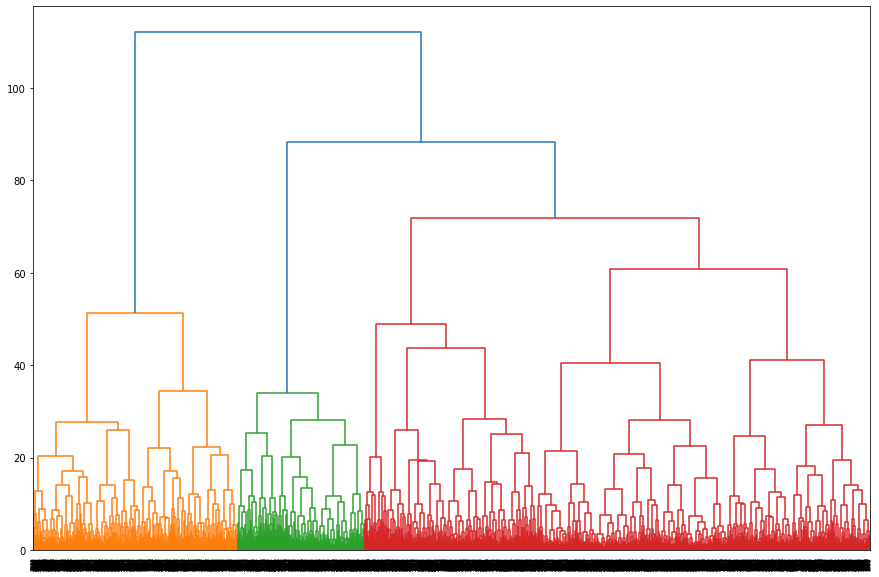

In [17]:
#выделим данные для кластеризации
X = gym_now.drop('churn', axis = 1)

#стандартизируем
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#строим таблицу расстояний между объектами
linked = linkage(X_sc, method = 'ward') 

#визуализируем
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Разобьём данные на 5 кластеров, красная часть получилась в несколько раз больше других. Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [18]:
km = KMeans(n_clusters = 5, random_state = 1)

#спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

#метки кластера в поле нашего датасета
gym_now['km_cluster'] = labels

#статистика по средним значениям наших признаков по кластеру
display(gym_now.groupby('km_cluster').agg('mean').T)
print('Размеры кластеров')
display(gym_now.groupby('km_cluster').agg(count=('age','count')))

#метрика силуэта для нашей кластеризации
print('Silhouette_score (метрика силуэта): {:.2f}'.format(silhouette_score(X_sc, labels)))

km_cluster,0,1,2,3,4
near_location,1.00,0.97,0.94,0.00,1.00
partner,0.24,0.27,0.74,0.47,0.82
promo_friends,0.02,0.10,0.49,0.08,1.00
contract_period,1.94,2.91,11.90,2.21,3.14
group_visits,0.33,0.47,0.55,0.22,0.45
age,28.20,30.29,29.90,28.47,29.15
avg_additional_charges_total,130.91,163.34,164.55,133.48,141.27
month_to_end_contract,1.86,2.67,10.89,2.08,2.92
lifetime,2.40,5.21,4.70,2.77,3.67
avg_class_frequency_total,1.30,2.90,1.99,1.65,1.72


Размеры кластеров


,count
km_cluster,
0,1124
1,761
2,935
3,542
4,638


Silhouette_score (метрика силуэта): 0.16


Самый склонный к оттоку кластер номер 0 (53% оттока) содержит в себе клиентов, живущих поблизости к фитнес-центру и по большей части не являющихся сотрудниками компаний-партнёров. У этого кластера самые низкие средние значения практически по всем остальным признакам(кроме групповых занятий).

Второй по проценту оттока кластер номер 3 (45% оттока) состоит из клиентов, живущих в отдалении от клуба. В остальном кластеры 0 и 3 схожи по своим параметрам. Кластер номер 3 имеет самое низкое значение среднего посещения групповых занятий, по остальным призакам он тоже близок кластеру номер 0.

Самый лояльный кластер номер 2 (2% оттока) имеет почти по всем признакам самые высокие средние значения, выделяется продолжительность абонементов (в среднем 11 месяцев) и количество месяцев до его окончания (11 месяцев).

Второй по надёжности или лояльности кластер номер 1 (6% оттока). В нем клиенты с высоким средним возрастом (30 лет) и самой высокой средней частотой посещения клуба (и за месяц и за неделю по три посещения).

Значение метрики силуэта оказалось не очень высоким. Скорее всего, вариаций кластеризации очень много и каждый из них нуждается в дополнительной трактовке и анализе.

Посмотрим на распределения признаков для кластеров.

In [19]:
#напишем функцию для отрисовки распредления и ящика с усами для непрерывных признаков
def cluster_nepreriv_feature_plots(df, feature, title):
    fig, ax = plt.subplots(figsize = (16, 4))

    #список кластеров
    cluster_names = df['km_cluster'].unique()  # [0, 1, 2, 3, 4]
    cluster_names = np.sort(cluster_names)
    
    #список датафреймов по кластерам
    clusters = [df.loc[df['km_cluster'] == i] for i in cluster_names]

    for cluster in clusters:
        sns.distplot(cluster[feature], label = cluster['km_cluster'].unique(), hist=False, ax = plt.subplot(1, 2, 1))
         
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()

    sns.boxplot(y = df[feature], x = df['km_cluster'], ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' по кластерам')
    plt.show()

In [20]:
#напишем функцию для отрисовки гистограммы и ящика с усами для категориальных признаков
def cluster_categor_feature_plots(df, feature, title):  
    fig, ax = plt.subplots(figsize = (16, 4))
    
    report = df.pivot_table(index = 'km_cluster', columns = feature, values = 'age', aggfunc = 'count')
    report.plot(kind = 'bar', stacked = True, alpha = 0.5, ax = plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()

    group = df.groupby([feature, 'km_cluster']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x='km_cluster', y='count', data=group, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' по кластерам')
    plt.show()

Строим графики для непрерывных:

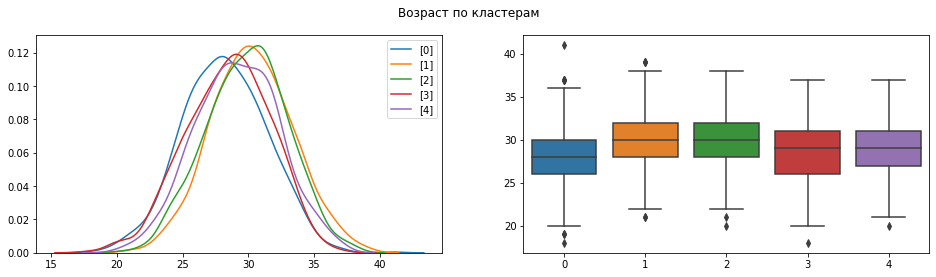

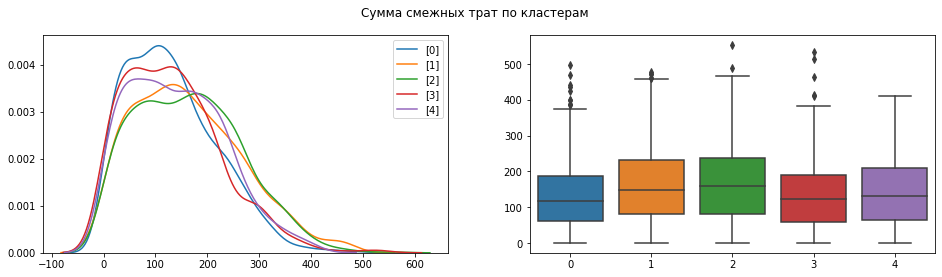

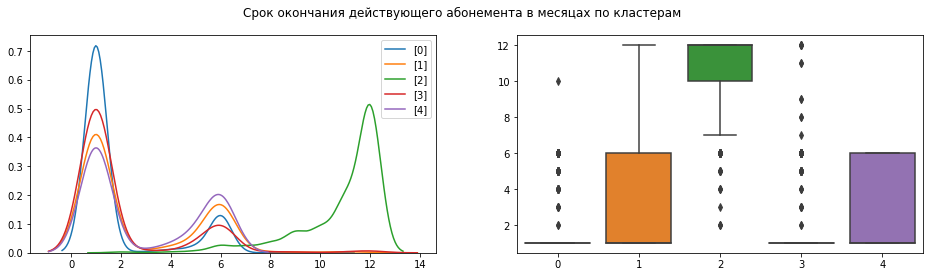

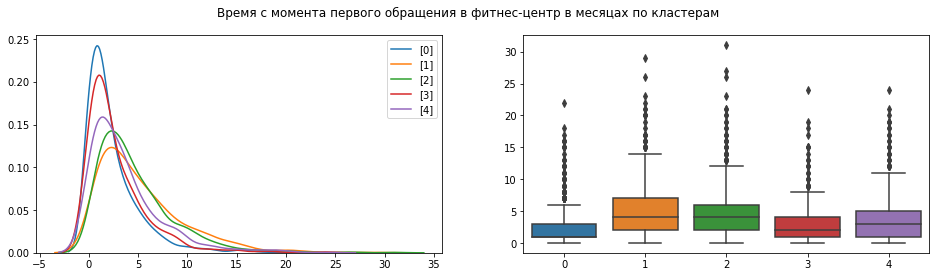

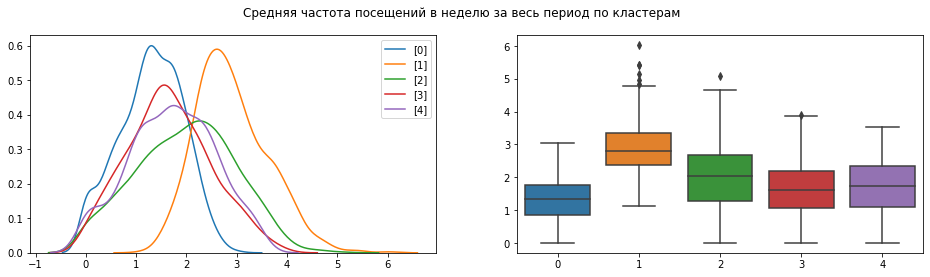

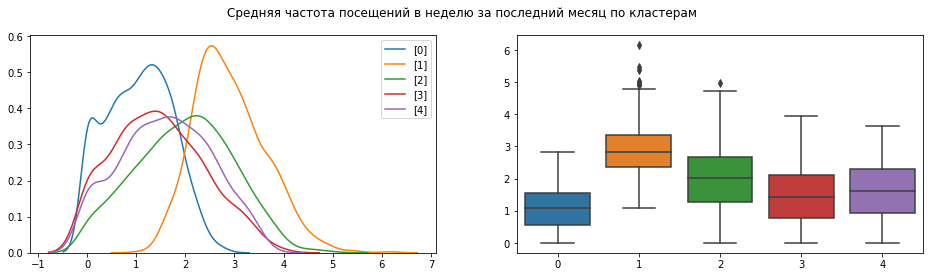

In [21]:
for index, row in nepreriv_features.iterrows():
    cluster_nepreriv_feature_plots(gym_now, row[0], row[1])

В самых надёжных кластерах (номера 1 и 2) оказалось больше возрастных клиентов, чем в остальных. Самый рискованный кластер (номер 0), смещён по оси возраста влево (самый молодой кластер).
В общем, можно заметить тенденцию, что все распределения упорядочены на оси x по их потенциалу оттока - левее и выше всех(чаще всего) кластер номер 0, затем 4 и 3.

Построим гистограммы дискретных признаков:

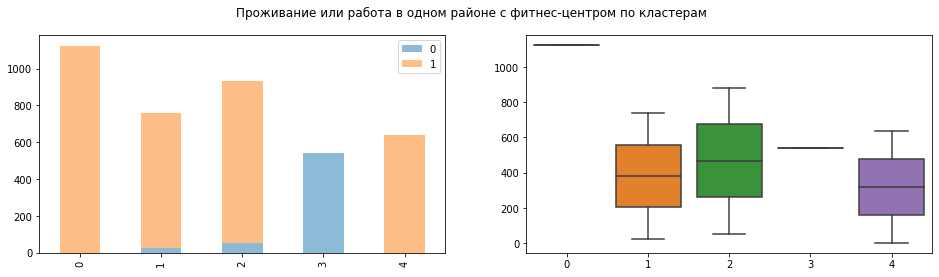

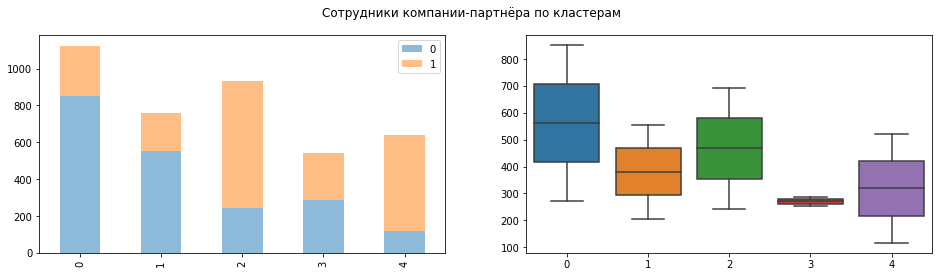

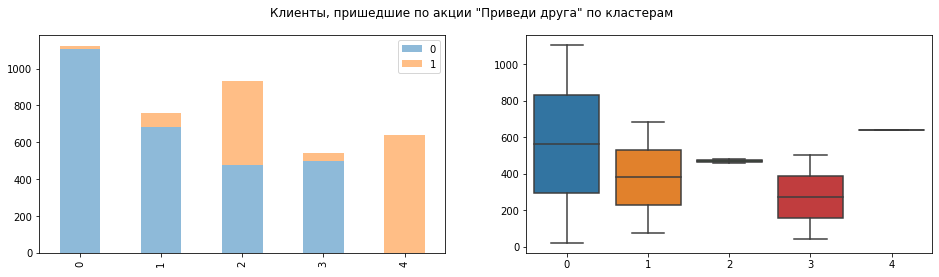

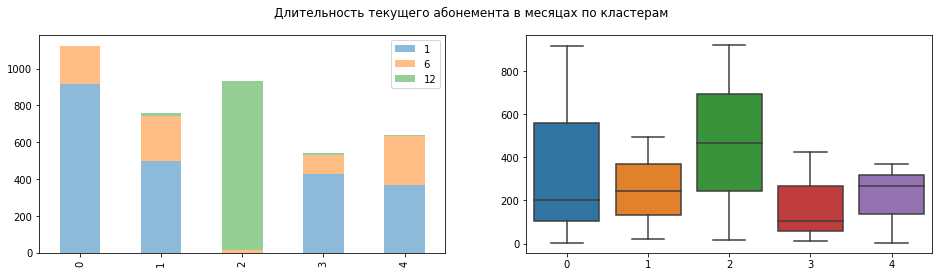

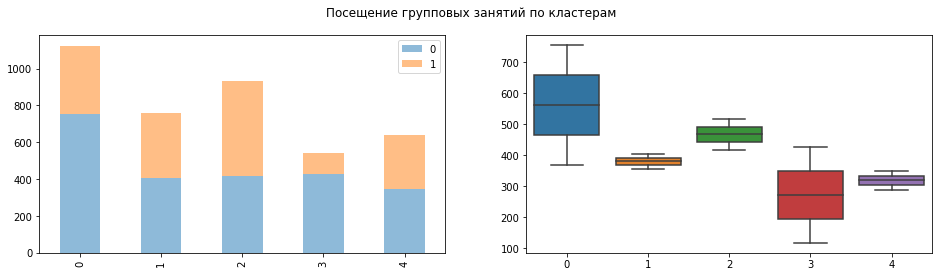

In [22]:
categor_features = categor_features[~categor_features['feature'].isin(['gender', 'phone'])]

for index, row in categor_features.iterrows():
    cluster_categor_feature_plots(gym_now, row[0], row[1])

В самом надёжном кластере (номер 2) оказалась наибольшая часть клиентов с абонементом на 12 месяцев, а в самый склонный к оттоку (номер 0), наибольшее количство клиентов с абонементом на 1 месяц, чем в остальные кластеры. Почти отсутствуют в кластере номер 0 и клиенты пришедшие по акции "Приведи друга". Стоит отметить, что в кластер номер 0 (самый склонный к оттоку) вошли клиенты, которые живут или работают в районе фитнес-центра.

## Выводы кластеризации
Мы стандартизировали данные, потом построили матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовали дендрограмму. Предположили, что стоит выделить 5 кластеров. Обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов. Посмотрели на средние значения признаков для кластеров и заметили, что самый склонный к оттоку кластер одновременно и самый молодой, и самый короткий по продолжительности абонемента клиентов внутри него. Также отметили наиболее лояльный кластеры и их признаки(почти все признаки выше, чем у склонных к оттоку, например, они больше тратять на смежные услуги, старше, дольше абонемент и т.д). Построили распределения признаков для кластеров.

# Выводы и рекомендации
Мы провели исследовательский анализ и подготовили данные, чтобы написать алгоритм для предсказывания оттока клиентов относительно следующего месяца с точностью 91%.

Определили признаки, влияющие на отток:
- lifetime клиента
- средняя частоста посещений клуба за последний месяц 
- возраст 
- срок действующего абонемента 
- количество месяцев до истечения абонемента 

Построили портреты пользователей разных кластеров:

In [23]:
gym_now.groupby('km_cluster').agg('mean').T

km_cluster,0,1,2,3,4
near_location,1.00,0.97,0.94,0.00,1.00
partner,0.24,0.27,0.74,0.47,0.82
promo_friends,0.02,0.10,0.49,0.08,1.00
contract_period,1.94,2.91,11.90,2.21,3.14
group_visits,0.33,0.47,0.55,0.22,0.45
age,28.20,30.29,29.90,28.47,29.15
avg_additional_charges_total,130.91,163.34,164.55,133.48,141.27
month_to_end_contract,1.86,2.67,10.89,2.08,2.92
lifetime,2.40,5.21,4.70,2.77,3.67
avg_class_frequency_total,1.30,2.90,1.99,1.65,1.72


Где самый склонный к оттоку кластер номер 0 (53% оттока) содержит в себе клиентов, живущих поблизости к фитнес-центру и по большей части не являющихся сотрудниками компаний-партнёров. У этого кластера самые низкие средние значения практически по всем остальным признакам(кроме групповых занятий).

Второй по проценту оттока кластер номер 3 (45% оттока) состоит из клиентов, живущих в отдалении от клуба. В остальном кластеры 0 и 3 схожи по своим параметрам. Кластер номер 3 имеет самое низкое значение среднего посещения групповых занятий, по остальным призакам он тоже близок кластеру номер 0.

Самый лояльный кластер номер 2 (2% оттока) имеет почти по всем признакам самые высокие средние значения, выделяется продолжительность абонементов (в среднем 11 месяцев) и количество месяцев до его окончания (11 месяцев).

Второй по надёжности или лояльности кластер номер 1 (6% оттока). В нем клиенты с высоким средним возрастом (30 лет) и самой высокой средней частотой посещения клуба (и за месяц и за неделю по три посещения).

Можно заметить тенденцию, что у самого надежного кластера в среднем самый высокие показатели в признаках, следовательно, стоит обратить внимание на увеличение средних значений признаков для уменьшения оттока клиентов. 

Рекомендации(все построены на логике перевода клиентов из одного кластера в другой):
- Клиентов, попавших в кластер номер 4, нужно стремиться перевести в кластер номер 2 за счёт предложения годового абонемента(на самом деле самое простое и рабочее решение по опыту) и стимуляции регулярного посещения.
- Клиентов из кластера номер 1 стоит так же пытать перевести в кластер номер 2, оба кластера очен похожи, основное отличие - срок абонемента(тоже стоит предлагать годовой)
- Клиентов из кластера номер 0, нужно постараться перевести в кластер номер 1 (один из надёжных и наиболее близкий к кластеру 0), но даже переход в кластер номер 4 будет для них прогрессом. Для этого стоит предлагать посещать групповые занятия, повысить регулярность тренировок в неделю и предлагать больше тратить на смежные услуги.
- Повышать для всех кластеров продолжительность абонемента и смежные траты(на практике это самые простые варианты, например, просто не продавать месячные абонементы, как делают большинство фитнес-центров, которые для пробы дают одно посещение и то не везде бесплатное). Лайфтайм при таком варианте будет расти сам собой, что тоже отрицательно вляет на отток.